In [1]:
import os
from copy import deepcopy
from pathlib import Path
import random
import shutil

from tqdm import tqdm
from pprint import pprint
import pandas as pd
import numpy as np
import nibabel as nib

from bcblib.tools.general_utils import open_json, save_json
from lesseg_unet.utils import get_sex_int, get_age_int

%load_ext autoreload
%autoreload 2

In [ ]:
from lesseg_unet.utils import get_perf_seg_dict, get_perf_seg_dict_from_folders
"""
First we need to create a dictionary with the segmentation files and the performance
"""
"""
INPUTS
"""
# Model trained with abnormals only (but with gen dice + focal loss)
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_abnormal_5fold_segmentation/'
# Model trained with both abnormals and ALL the controls (but with gen dice + focal loss)
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_controls_5fold_segmentation/'
# Model trained with both abnormals and the controls (but with gen dice + focal loss) without  biobank images
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_training_with_controls_gendice_focal_no_biobank/'

# Model trained with both abnormals and ALL the controls with dice + focal loss and a 0.1 weight on control loss
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div10_dicefocal/'
# Model trained with both abnormals and ALL the controls with dice + focal loss and a 0.001 weight on control loss
# seg_folder = '/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal'
# output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal/'

# Simple UNet trained with abnormals only and without any augmentation
seg_folder = '/media/chrisfoulon/HDD2/final_training_set/abnormal_training_no_augs_unet'
output_folder = '/media/chrisfoulon/HDD2/final_training_set/perf_labels_abnormal_training_no_augs_unet/'



In [ ]:


spm_seg_folder = Path(output_folder, 'spm_segmentation')
os.makedirs(output_folder, exist_ok=True)
os.makedirs(spm_seg_folder, exist_ok=True)

keys_struct = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict.json')

if Path(seg_folder, '__output_image_volumes.json').exists():
    seg_dict = get_perf_seg_dict(seg_folder, keys_struct=keys_struct, relative_output_paths=False)
else:
    print('process from folders')
    seg_dict = get_perf_seg_dict_from_folders(seg_folder, keys_struct=keys_struct, relative_output_paths=False)
# print first value of the dict
pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})
# Then we need to copy the segmentation files to a separate folder for SPM ...
output_masks_folder = Path(output_folder, 'output_masks/')
output_labels_folder = Path(output_folder, 'output_labels/')
os.makedirs(output_masks_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)
spm_seg_dict = {}
main_key_to_process = 'label'
# main_key_to_process = 'segmentation'
for k in tqdm(seg_dict):
    shutil.copy(seg_dict[k]['segmentation'], output_masks_folder)
    shutil.copy(seg_dict[k]['label'], output_labels_folder)
    spm_seg_dict[k] = deepcopy(seg_dict[k])
    spm_seg_dict[k][main_key_to_process] = str(Path(spm_seg_folder, Path(seg_dict[k][main_key_to_process]).name.split('.gz')[0]))
    nib.save(nib.load(seg_dict[k][main_key_to_process]), spm_seg_dict[k][main_key_to_process])
print(len(seg_dict))
pprint({k: seg_dict[k] for k in random.sample(seg_dict.keys(), 1)})

save_json(Path(seg_folder, 'perf_seg_dict.json'), seg_dict)
save_json(Path(seg_folder, 'spm_perf_seg_dict.json'), spm_seg_dict)

In [ ]:
"""
Then we need to create a dataframe with the performance metrics
"""
columns=[main_key_to_process, 'dice_metric', 'distance', 'volume', 'lesion_cluster', 'PatientAge', 'PatientSex']
b1000_info_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict.json')


# dict_for_df = {}
# for k in seg_dict:
#     for col in columns:
#         if col in seg_dict:
#             dict_for_df[k][col] = seg_dict[k][col]
#         else:
#             dict_for_df[k][col] = b1000_info_dict[k][col]
#
# pprint({k: dict_for_df[k] for k in random.sample(dict_for_df.keys(), 1)})
# new_df = pd.DataFrame.from_records(dict_for_df).T
# new_df.to_csv(Path(seg_folder, 'segmentation_perf_df.csv'), columns=columns)

# create a function to do that
def get_df_from_dict(seg_dict, columns):
    dict_for_df = {}
    for k in seg_dict:
        dict_for_df[k] = {}
        for col in columns:
            if col in seg_dict[k]:
                if col == 'PatientAge':
                    dict_for_df[k][col] = get_age_int(seg_dict[k][col])
                elif col == 'PatientSex':
                    dict_for_df[k][col] = get_sex_int(seg_dict[k][col])
                else:
                    dict_for_df[k][col] = seg_dict[k][col]
            elif col == 'lesion_cluster':
                dict_for_df[k][col] = Path(seg_dict[k][main_key_to_process]).parent.name
            else:
                if col == 'PatientAge':
                    dict_for_df[k][col] = get_age_int(b1000_info_dict[k][col])
                elif col == 'PatientSex':
                    dict_for_df[k][col] = get_sex_int(b1000_info_dict[k][col])
                else:
                    dict_for_df[k][col] = b1000_info_dict[k][col]
    new_df = pd.DataFrame.from_records(dict_for_df).T
    return new_df

# use it on seg_dict and spm_seg_dict
new_df = get_df_from_dict(seg_dict, columns)
new_df.to_csv(Path(output_folder, 'segmentation_perf_df.csv'), columns=columns)
new_df = get_df_from_dict(spm_seg_dict, columns)
new_df.to_csv(Path(output_folder, 'spm_segmentation_perf_df.csv'), columns=columns)

In [ ]:
"""
Then we need to zscore the columns
"""
zcores_columns = ['dice_metric', 'distance', 'volume', 'PatientAge', 'PatientSex']
for col in zcores_columns:
    # pd.to_numeric(new_df[col])
    new_df[col] = new_df[col].infer_objects()
#     print(col)
#     print(new_df[col].dtype)
#     new_df[col] = new_df[col].apply(stats.zscore)
normalized_df = new_df[zcores_columns]
normalized_df=(normalized_df-normalized_df.mean())/normalized_df.std()
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
new_df[zcores_columns] = normalized_df[zcores_columns]
new_df.to_csv(Path(seg_folder, 'segmentation_perf_df_zscored.csv'), columns=columns)

In [ ]:
from nilearn.image import smooth_img
# smooth all the images from the segmentation dict with key 'segmentation' and save them in '/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation_masks_smoothed_8'
smooth_out_folder = output_folder + 'masks_smoothed_8'
os.makedirs(smooth_out_folder, exist_ok=True)
spm_smoothed_seg_dict = {}
for k in tqdm(spm_seg_dict):
    smoothed_img = smooth_img(spm_seg_dict[k][main_key_to_process], 8)
    spm_smoothed_seg_dict[k] = deepcopy(spm_seg_dict[k])
    spm_smoothed_seg_dict[k][main_key_to_process] = str(Path(smooth_out_folder, Path(spm_seg_dict[k][main_key_to_process]).name))
    nib.save(smoothed_img, spm_smoothed_seg_dict[k][main_key_to_process])



In [ ]:
new_df = get_df_from_dict(spm_smoothed_seg_dict, columns)
new_df.to_csv(Path(output_folder, 'spm_smoothed_segmentation_perf_df.csv'), columns=columns)
# STOP HERE FOR SIMPLE MODEL/DICE SPM COMPARISON

In [4]:
# Now, we use the spm_smoothed_segmentation_perf_df.csv from each directory in model_perf_dir_list and create a new multi_model_dice_comparison_df
model_perf_dir_list = [
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_analyses_abnormal_5fold_segmentation',
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div10_dicefocal',
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_control_training_wf_div1000_dicefocal',
    '/media/chrisfoulon/HDD2/final_training_set/perf_labels_training_with_controls_gendice_focal_no_biobank'
]

model_perf_df_list = [
    pd.read_csv(Path(model_perf_dir, 'spm_smoothed_segmentation_perf_df.csv'), index_col=0)
    for model_perf_dir in model_perf_dir_list
]

multi_model_dice_comparison_df = pd.DataFrame()
# add the 'label' column of the first df to multi_model_dice_comparison_df
multi_model_dice_comparison_df['label'] = model_perf_df_list[0]['label']
# add the 'dice_metric' column of each df to multi_model_dice_comparison_df (with folder name as column name + '_dice_metric')
for i, model_perf_df in enumerate(model_perf_df_list):
    multi_model_dice_comparison_df[model_perf_dir_list[i].split('/')[-1] + '_dice_metric'] = model_perf_df['dice_metric']

b1000_ground_truths_label_seize_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')

# keys in b1000_ground_truths_label_seize_dict are the same as in multi_model_dice_comparison_df[0] first column. Match them and add the label size to multi_model_dice_comparison_df
multi_model_dice_comparison_df['label_size'] = [b1000_ground_truths_label_seize_dict[k]['label_size']  for k in multi_model_dice_comparison_df.index]

# save the multi_model_dice_comparison_df
multi_model_dice_comparison_df.to_csv('/media/chrisfoulon/HDD2/final_training_set/multi_model_dice_comparison_df.csv', columns=multi_model_dice_comparison_df.columns)

In [ ]:
from lesseg_unet.utils import weight_lesion_dataset

biobank_ctr_folder_name = 'perf_analyses_controls_5fold_segmentation'
no_biobank_ctr_folder_name = 'perf_training_with_controls_gendice_focal_no_biobank'
ctr_folder_name = no_biobank_ctr_folder_name

abnormal_df_path = Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'spm_smoothed_segmentation_perf_df.csv')
controls_df_path = Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'spm_smoothed_segmentation_perf_df.csv')

abnormal_weighted_output_folder = Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'dice_weighted_smoothed_lesions')
controls_weighted_output_folder = Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'dice_weighted_smoothed_lesions')

# weight the images of the abnormal dataset
abnormal_weighted_dict, abnormal_weighted_df = weight_lesion_dataset(abnormal_df_path, 'segmentation', 'dice_metric', abnormal_weighted_output_folder, 'Unnamed: 0')
# save the weighted dataframe
abnormal_weighted_df.to_csv(Path('/media/chrisfoulon/HDD2/final_training_set/perf_analyses_abnormal_5fold_segmentation/', 'dice_weighted_smoothed_lesions_segmentation_perf_df.csv'), columns=abnormal_weighted_df.columns)

# weight the images of the controls dataset
controls_weighted_dict, controls_weighted_df = weight_lesion_dataset(controls_df_path, 'segmentation', 'dice_metric', controls_weighted_output_folder, 'Unnamed: 0')
# save the weighted dataframe
controls_weighted_df.to_csv(Path(f'/media/chrisfoulon/HDD2/final_training_set/{ctr_folder_name}/', 'dice_weighted_smoothed_lesions_segmentation_perf_df.csv'), columns=controls_weighted_df.columns)


# for each row in abnormal_weighted_df, find the corresponding row in controls_weighted_df using 'Unnamed: 0'
# then compute the substraction of the nifti images in 'weighted_path' and save the result in a new folder
dice_substraction_folder = Path('/media/chrisfoulon/HDD2/final_training_set/', 'dice_subtraction_smoothed_lesions_no_biobank')
os.makedirs(dice_substraction_folder, exist_ok=True)
for row in tqdm(abnormal_weighted_df.iterrows()):
    key = row[1]['Unnamed: 0']
    abnormal_path = row[1]['weighted_path']
    abnormal_nifti = nib.load(abnormal_path)
    abnormal_data = abnormal_nifti.get_fdata()
    control_path = controls_weighted_df[controls_weighted_df['Unnamed: 0'] == key]['weighted_path'].values[0]
    control_nifti = nib.load(control_path)
    control_data = control_nifti.get_fdata()
    dice_substraction = abnormal_data - control_data
    dice_substraction_nifti = nib.Nifti1Image(dice_substraction, affine=abnormal_nifti.affine)
    nib.save(dice_substraction_nifti, Path(dice_substraction_folder, Path(abnormal_path).name.replace('.nii.gz', '.nii')))

In [4]:
# Now, we want to compute the mean dice_metric between a list of perf_seg_dict and save the {key: 'mean_dice_metric': value, 'mean_distance': value_average_distance} in a new dict
perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]

mean_dice_dict = {}
for k in perf_seg_dict_list[0]:
    mean_dice_dict[k] = {}
    mean_dice_dict[k]['mean_dice_metric'] = np.mean([d[k]['dice_metric'] for d in perf_seg_dict_list])
    mean_dice_dict[k]['mean_distance'] = np.mean([d[k]['distance'] for d in perf_seg_dict_list])
    
# sort the dict by mean_dice_metric (ascending)
mean_dice_dict = {k: v for k, v in sorted(mean_dice_dict.items(), key=lambda item: item[1]['mean_dice_metric'])}
    
save_json(Path('/media/chrisfoulon/HDD2/final_training_set/', 'mean_dice_dict.json'), mean_dice_dict)

In [4]:
mean_dice_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/mean_dice_dict.json')
# print all values with mean_distance = 0
for k in mean_dice_dict:
    if mean_dice_dict[k]['mean_distance'] == 0:
        print(k)
        print(mean_dice_dict[k]['mean_dice_metric'])
        print(mean_dice_dict[k]['mean_distance'])

DTI_P6d_noniso_SENSE_20150731120209_301__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20180301104234_201__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160618125529_201__pref__
0.0
0.0
ep2d_diff_3scan_trace_20070324110557_9__pref__
0.0
0.0
ep2d_diff_3scan_ipat_20141022143252_6__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160722100258_201__pref__
0.0
0.0
DTI_P6d_noniso_SENSE_20160711083742_201__pref__
0.0
0.0
DTI_P6d_noniso_20190112135713_201__pref__
0.9755767226219177
0.0
1.3.46.670589.11.38075.5.0.1820.2018040815523831006_20180408155238_201__pref__
0.9875420689582824
0.0
DTI_P6d_noniso_20190315163801_201__pref__
0.987842321395874
0.0
1.2.840.846310145.12.1.1.60286619_20180831163807_201__pref__
0.9879709959030152
0.0
1.2.840.846310145.12.1.1.60317294_20180915142847_201__pref__
0.9880144834518433
0.0
1.2.840.846310145.12.1.1.60692052_20190315163801_201__pref__
0.9884455084800721
0.0
DTI_P6d_noniso_SENSE_20180718155058_201__pref__
0.9889434337615967
0.0
DTI_P6d_noniso_SENSE_20151214153600_301__pref__
0.9917016

In [12]:
from bcblib.tools.visualisation import display_img

perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]
# For every image with a mean_dice_metric <= 0, display perf_seg_dict_list[-2][k]['b1000'] with display_img
for k in mean_dice_dict:
    if 0.01 < mean_dice_dict[k]['mean_dice_metric'] <= 0.2 and 0.5 < mean_dice_dict[k]['mean_distance'] < 3:
        print(k)
        print(mean_dice_dict[k]['mean_dice_metric'])
        print(mean_dice_dict[k]['mean_distance'])
        # display_img(perf_seg_dict_list[-2][k]['b1000'], perf_seg_dict_list[-2][k]['label'], display='fsleyes')
        display_img(perf_seg_dict_list[-2][k]['b1000'], perf_seg_dict_list[-2][k]['label'], perf_seg_dict_list[-2][k]['segmentation'], display='fsleyes')

DTI_P6d_noniso_SENSE_20151112143421_301__pref__
0.04636363759636878
2.9771296018981586
Fsleyes command: "fsleyes /media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_images/non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000.nii.gz /media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/fold_2/val_images/empty_prediction/label_non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000_v0v_71.nii.gz -cm red -a 40 /media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/fold_2/val_images/empty_prediction/output_non_linear_co-rigid_rigid_geomean_denoise_DTI_P6d_noniso_SENSE_20151112143421_301__pref___bval1000_v0v_71.nii.gz -cm green -a 40"
Error/Warning during fsleyes execution
exit status: 0
stderr: given by the platformdirs library.  To remove this warning and
see the appropriate new directories, set the environment variable
`JUPYTER_PLATFORM_DIRS=1`

KeyboardInterrupt: 

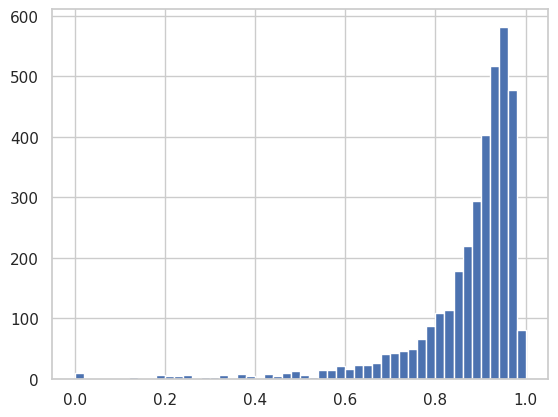

In [12]:
# plot the distribution of the mean_dice_metric
import matplotlib.pyplot as plt
plt.hist([mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict], bins=50)
plt.show()

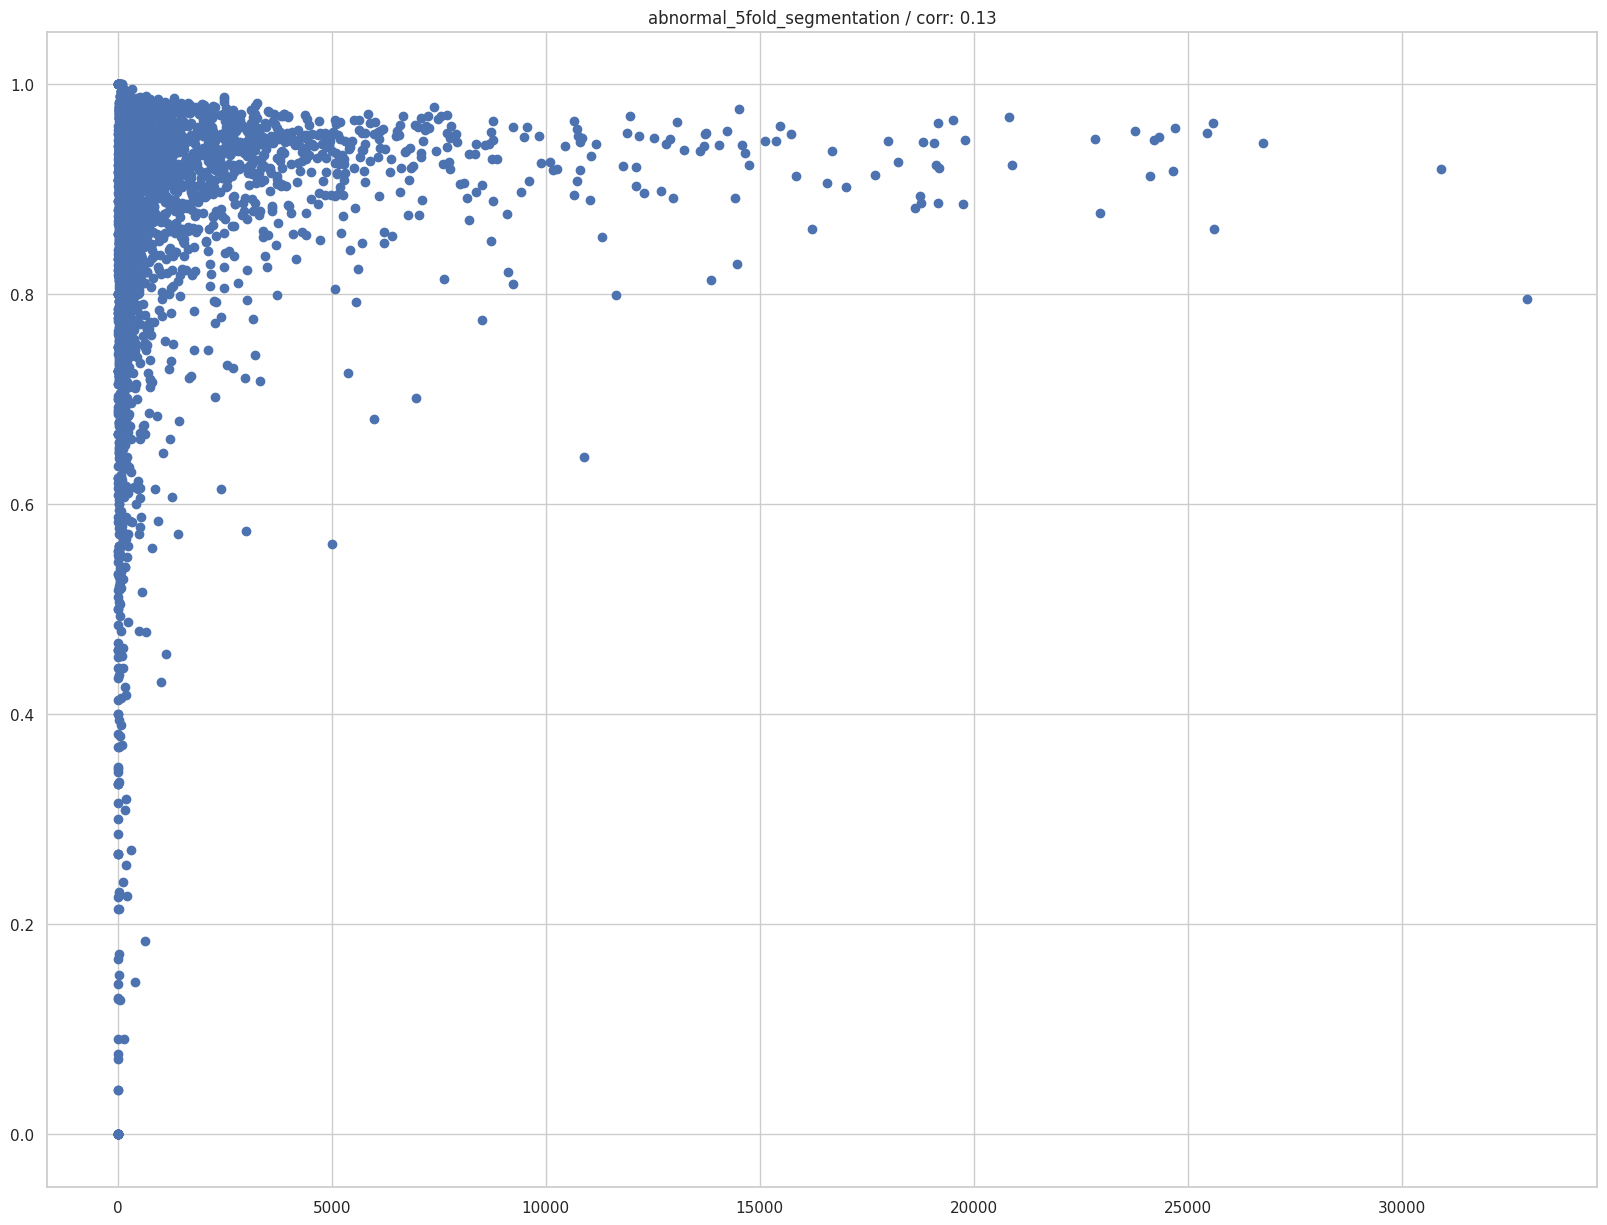

PearsonRResult(statistic=0.1256379784938666, pvalue=5.205894311170442e-14)


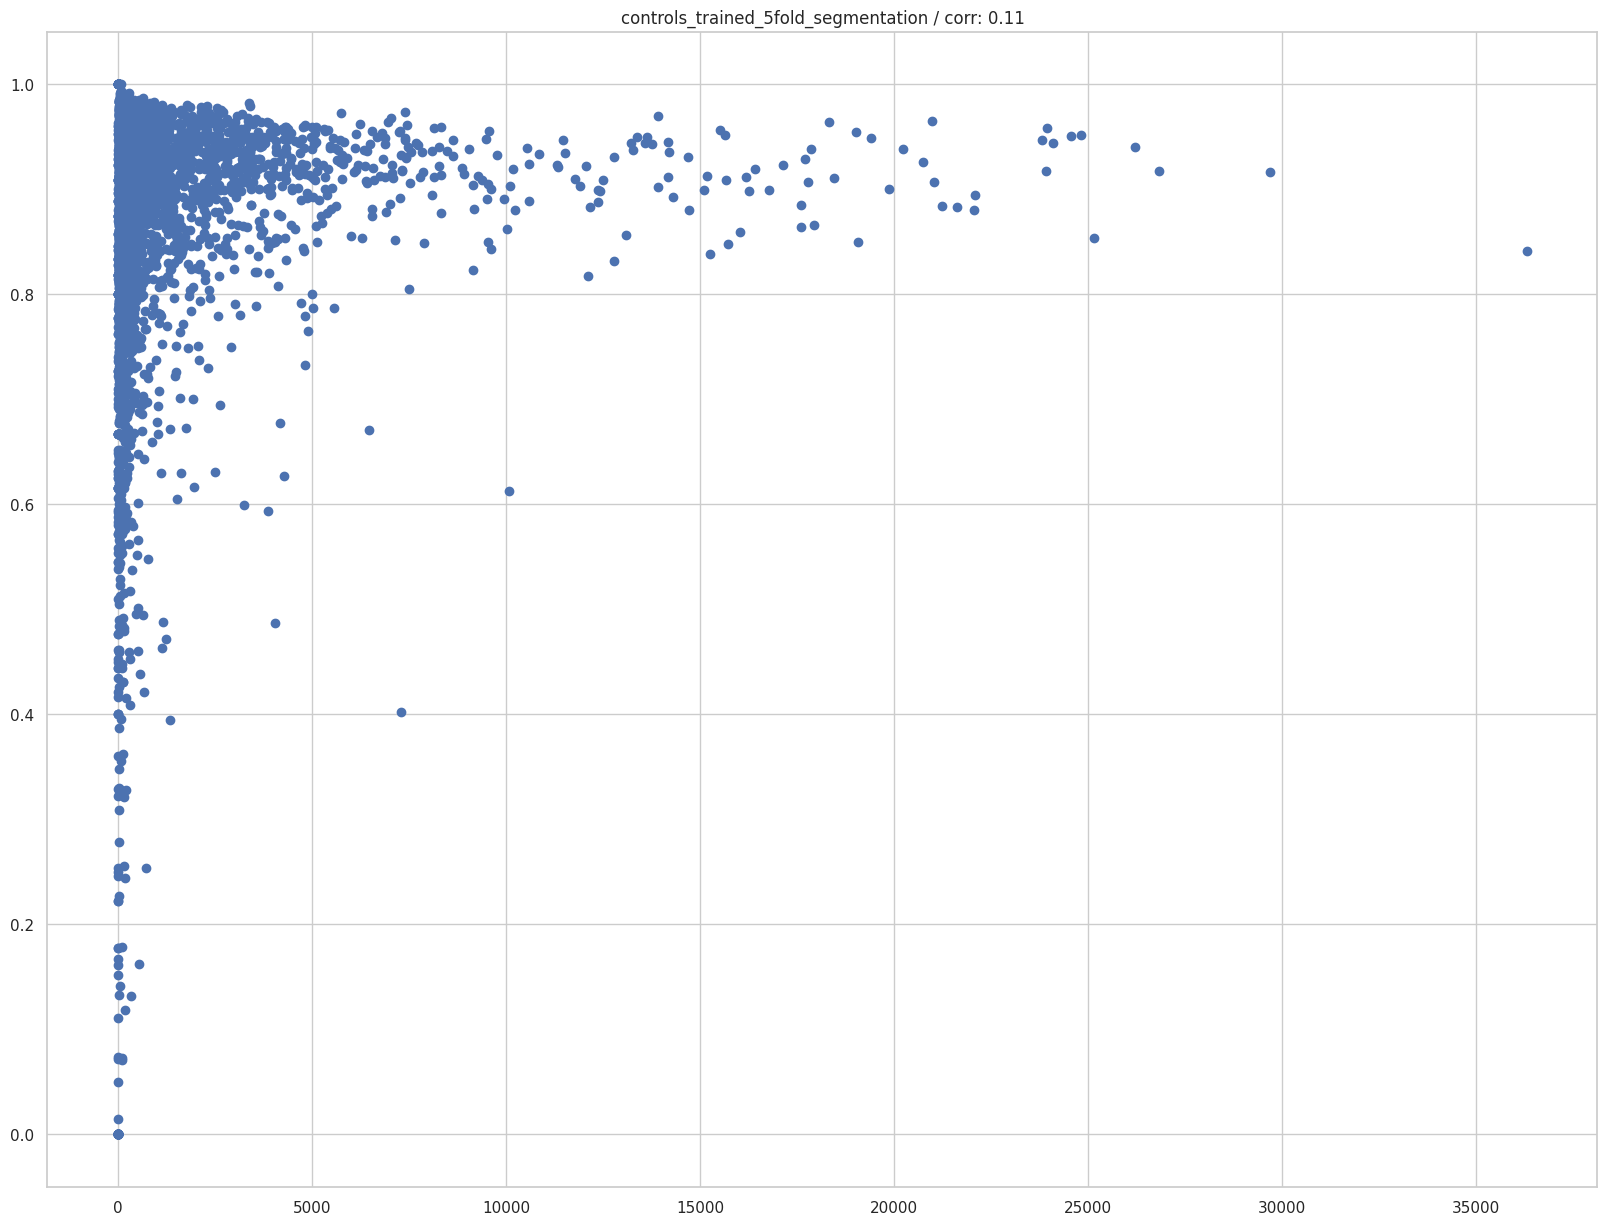

PearsonRResult(statistic=0.11137353979787033, pvalue=2.621555276038368e-11)


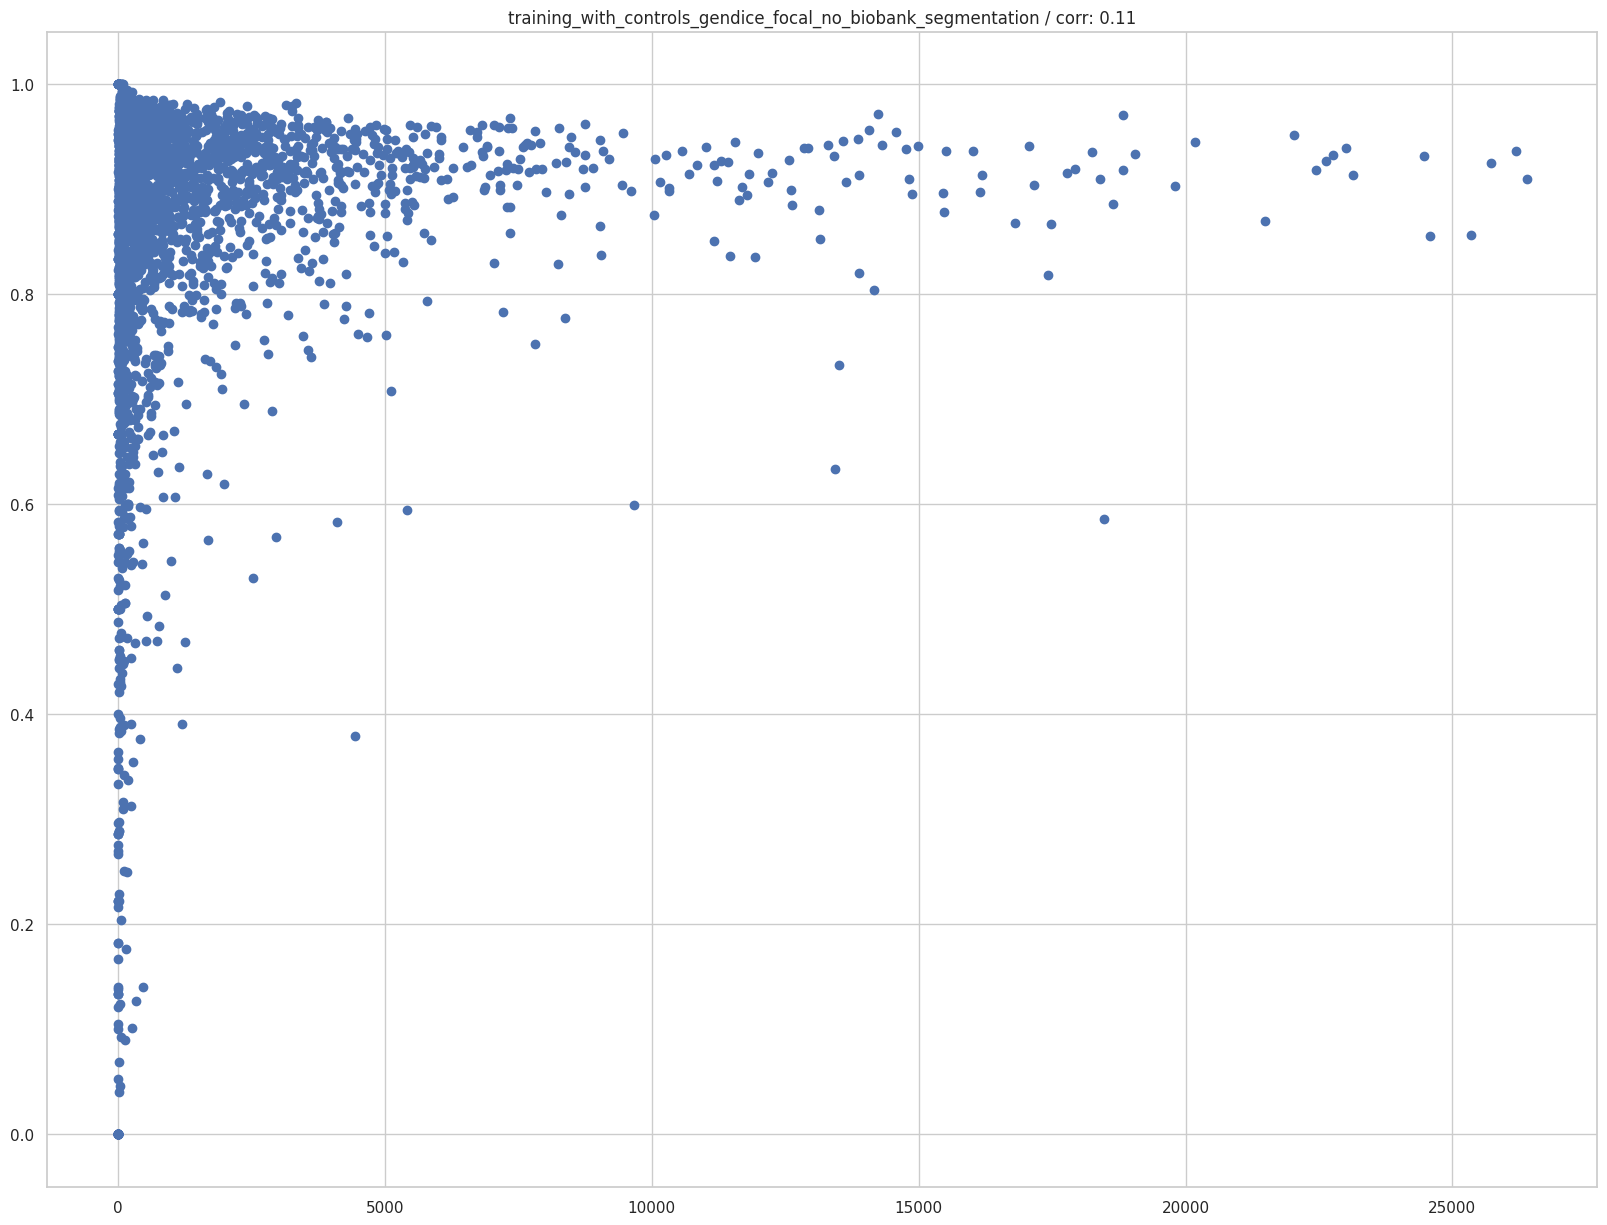

PearsonRResult(statistic=0.1061693453651513, pvalue=2.1104663440763623e-10)


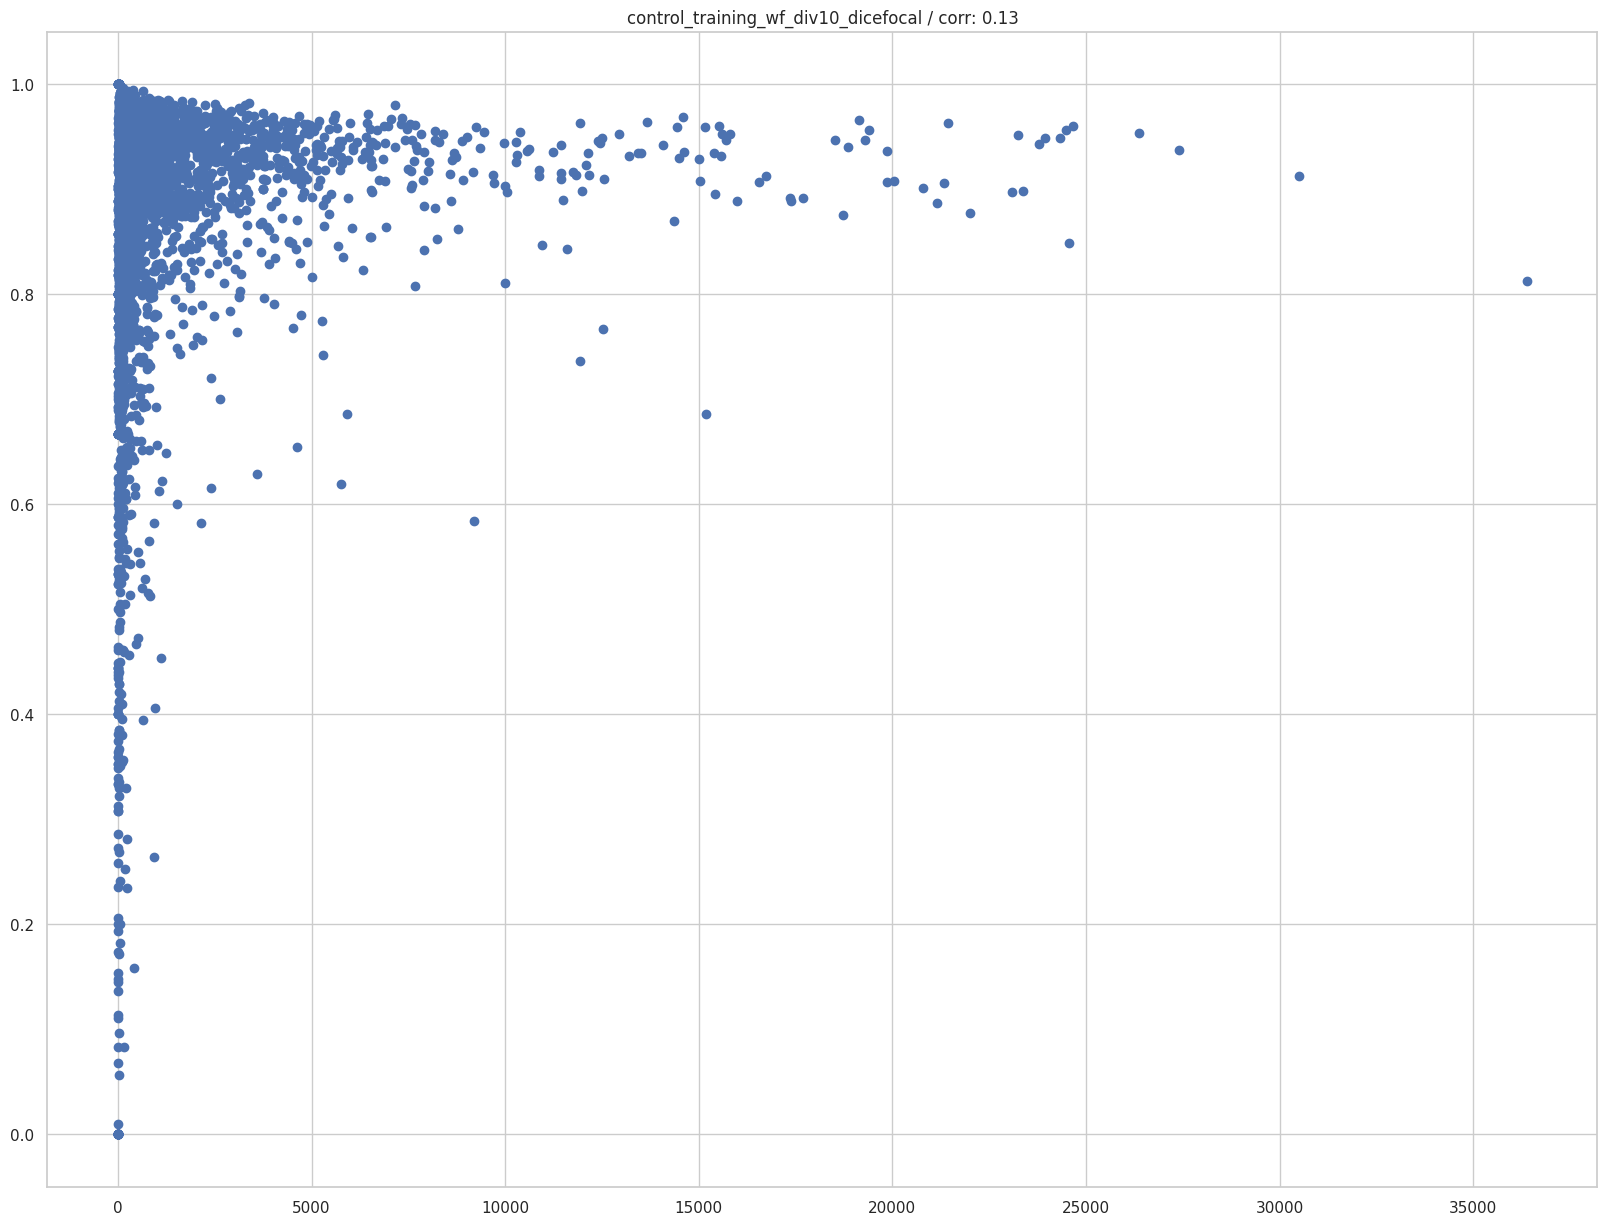

PearsonRResult(statistic=0.125017495688566, pvalue=6.930381126613504e-14)


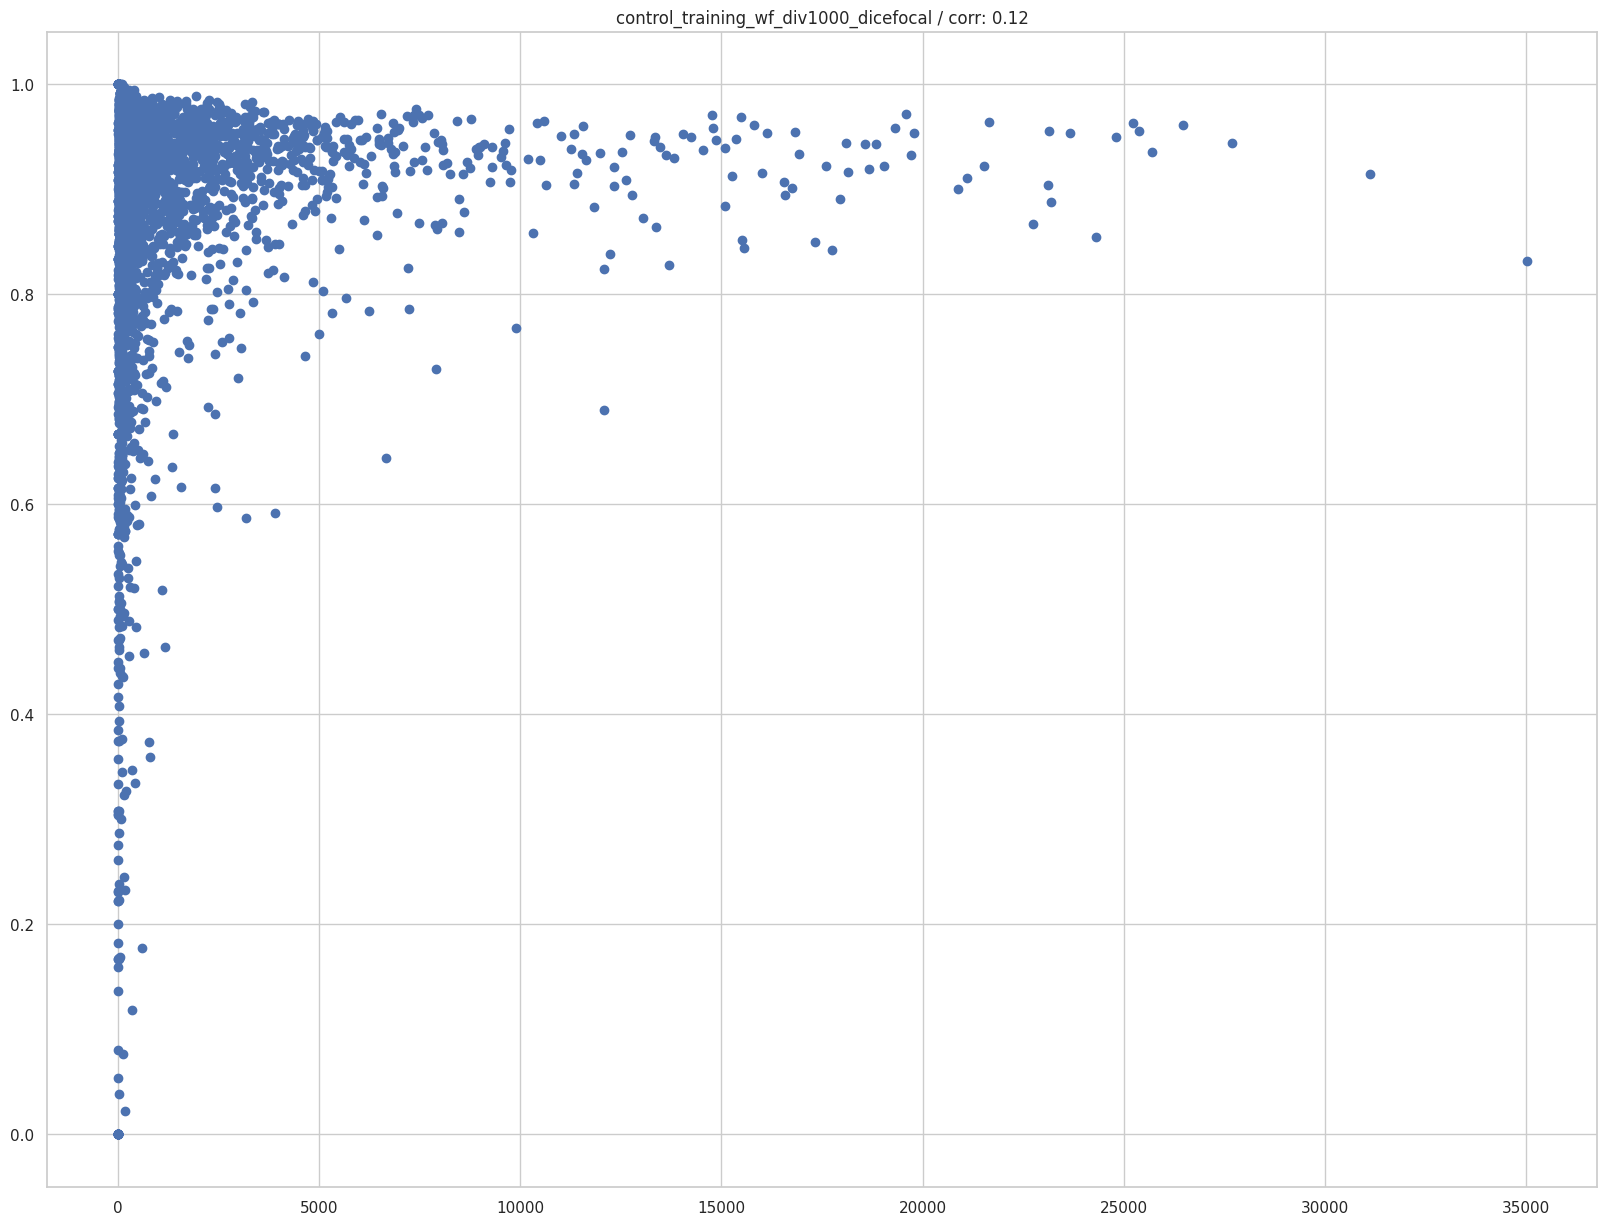

PearsonRResult(statistic=0.1226879101248712, pvalue=2.0036142276692285e-13)


In [20]:
perf_seg_dict_list = [
    open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/controls_trained_5fold_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/training_with_controls_gendice_focal_no_biobank_segmentation/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div10_dicefocal/perf_seg_dict.json'),
    open_json('/media/chrisfoulon/HDD2/final_training_set/control_training_wf_div1000_dicefocal/perf_seg_dict.json')
]

perf_seg_dict_parent_folder_name_list = [
    'abnormal_5fold_segmentation',
    'controls_trained_5fold_segmentation',
    'training_with_controls_gendice_focal_no_biobank_segmentation',
    'control_training_wf_div10_dicefocal',
    'control_training_wf_div1000_dicefocal'
]

# display the distribution of the dice_metric for each dataset related to the volume of the lesion and compute the correlation between the two on each plot 
from scipy.stats import pearsonr
# make plots taller and larger
plt.rcParams['figure.figsize'] = [20, 15]
for i, perf_seg_dict in enumerate(perf_seg_dict_list):
    # print(perf_seg_dict_parent_folder_name_list[i])
    plt.scatter([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict])
    corr = pearsonr([perf_seg_dict[k]['volume'] for k in perf_seg_dict], [perf_seg_dict[k]['dice_metric'] for k in perf_seg_dict])
    plt.title(f'{perf_seg_dict_parent_folder_name_list[i]} / corr: {corr[0]:.2f}')
    plt.show()
    print(corr)

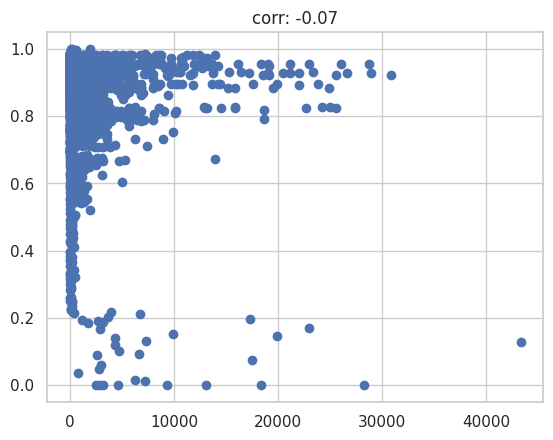

PearsonRResult(statistic=-0.07214794158358694, pvalue=1.627528355889108e-05)


In [18]:
# do the same but for the label size from b1000_label_dict and the mean_dice_metric from the mean_dice_dict
b1000_label_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/cleaned_abnormal_b1000_info_dict_label_size.json')
plt.scatter([b1000_label_dict[k]['label_size'] for k in b1000_label_dict], [mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict])
corr = pearsonr([b1000_label_dict[k]['label_size'] for k in b1000_label_dict], [mean_dice_dict[k]['mean_dice_metric'] for k in mean_dice_dict])
plt.title(f'corr: {corr[0]:.2f}')
plt.show()
print(corr)


In [16]:
from lesseg_unet.loss_and_metric import distance_ratio
perf_seg_dict = open_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict.json')
first_label = perf_seg_dict[list(perf_seg_dict.keys())[0]]['label']
first_seg = perf_seg_dict[list(perf_seg_dict.keys())[0]]['segmentation']
# print first distance
print(perf_seg_dict[list(perf_seg_dict.keys())[0]]['distance'])
print(distance_ratio(first_label, first_seg))
def perf_seg_dict_add_distance_ratio(perf_seg_dict_path, output_path):
    perf_seg_dict = open_json(perf_seg_dict_path)
    for k in tqdm(perf_seg_dict):
        # add the distance_ratio to the perf_seg_dict and then add the average of dice_metric and distance_ratio to the dice_dist_ratio 
        perf_seg_dict[k]['distance_ratio'] = distance_ratio(perf_seg_dict[k]['label'], perf_seg_dict[k]['segmentation'])
        perf_seg_dict[k]['dice_dist_ratio'] = (perf_seg_dict[k]['dice_metric'] + perf_seg_dict[k]['distance_ratio']) / 2
    # sort the dict by dice_dist_ratio (ascending)
    perf_seg_dict = {k: v for k, v in sorted(perf_seg_dict.items(), key=lambda item: item[1]['dice_dist_ratio'])}
    # save the perf_seg_dict
    save_json('/media/chrisfoulon/HDD2/final_training_set/abnormal_5fold_segmentation/perf_seg_dict_with_distance_ratio.json', perf_seg_dict)

2.0
tensor([[0.9858]])


100%|██████████| 3563/3563 [02:36<00:00, 22.81it/s]


TypeError: Object of type Tensor is not JSON serializable